# Fitness scores within trees

This notebook shows how to use jungle to calculate the fitness scores for nodes within a tree. This involves the following steps.

1. Load trees.
2. Calculate fitness scores.
3. Plot the trees colored by fitness scores.
4. Examine properties of the fitness scores and how they relate to other tree features.
5. Export the fitness scores and other features to a file.

# Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import ete3

# Trees cannot be rendered without an X backend
# Virtual X backend solves this problem.
# To use this, install xvfb and run jupyter notebook/lab in the xvfb environment.
# apt get xvfb
# xvfb-run jupyter 

In [2]:
# Set plot display options
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
mpl.rc('savefig', dpi=300)

In [3]:
# Because of a bug in Jupyter, this needs to be run twice
mpl.rcParams.update(params)
mpl.rc('savefig', dpi=300)

In [4]:
sys.path.append("../../jungle/") # specify path to jungle
import jungle as jg

# Load empirical trees

We load two trees. One, called neutral, was generated by a model of neutral drift, called the Kingman coalescent. The other one called, positive selection, was generated by a model of positive selection, called the Bolthausen-Sznitman coalescent.

In [5]:
# Load trees from Newick files
infiles = ["Tree_neutral.nwk", "Tree_positive_selection.nwk"]
F_empirical = jg.Forest.from_newick(infiles)

print len(F_empirical), "trees"
print

2 trees



In [6]:
# Show size of trees
print "Size of trees:"
for tree in F_empirical.trees:
    print len(tree), "leaves"

Size of trees:
500 leaves
500 leaves


In [7]:
# Set the names of the trees (for display)
names_trees = ["Tree_neutral", "Tree_positive_selection"]

# Calculate fitness scores and other features

We calculate the fitness score. The fitness score is calculated by integrating the local branch length around each node. This essentially measures how rapidly branching the tree is in each region. The calculate uses code from this reference (https://elifesciences.org/articles/03568).

We also annotate each node with other features, such as its depth, number of children, and number of direct descendants.

In [8]:
%%time

# Annotate each node with standard features, including its depth, number of children, and number of direct descendants.

F_empirical.annotate_standard_node_features()

CPU times: user 2.23 s, sys: 9.85 ms, total: 2.24 s
Wall time: 2.24 s


In [9]:
%%time

# Calculate fitness scores for the empirical trees

F_empirical.infer_fitness(params={})

node_ranking: inferring ancestral fitness... done in  2.29 s
node_ranking: calculating alternative rankings... done in  0.5 s
node_ranking: inferring ancestral fitness... done in  12.12 s
node_ranking: calculating alternative rankings... done in  0.27 s
CPU times: user 31.5 s, sys: 94.7 ms, total: 31.6 s
Wall time: 31.6 s


# Visualize fitness scores

To visualize the fitness scores, we color the tree by the score.

In [10]:
# Set attribute for color
for T in F_empirical.trees:
    T.color(by="mean_fitness", cmap=mpl.cm.plasma)  # colormap can be chosen here

In [11]:
# Set tree style
# Trees are ETE3 objects, so you can use all ETE3 options to change how they are displayed
import ete3
ts = ete3.TreeStyle()
ts.mode = "c"  # circular trees
ts.arc_start = -180
ts.arc_span = 350

In [12]:
# Uncomment this to save the images as files.

filenames = [name + ".png" for name in names_trees] # specify the filenames

# F_empirical.render(filenames, dpi=300)

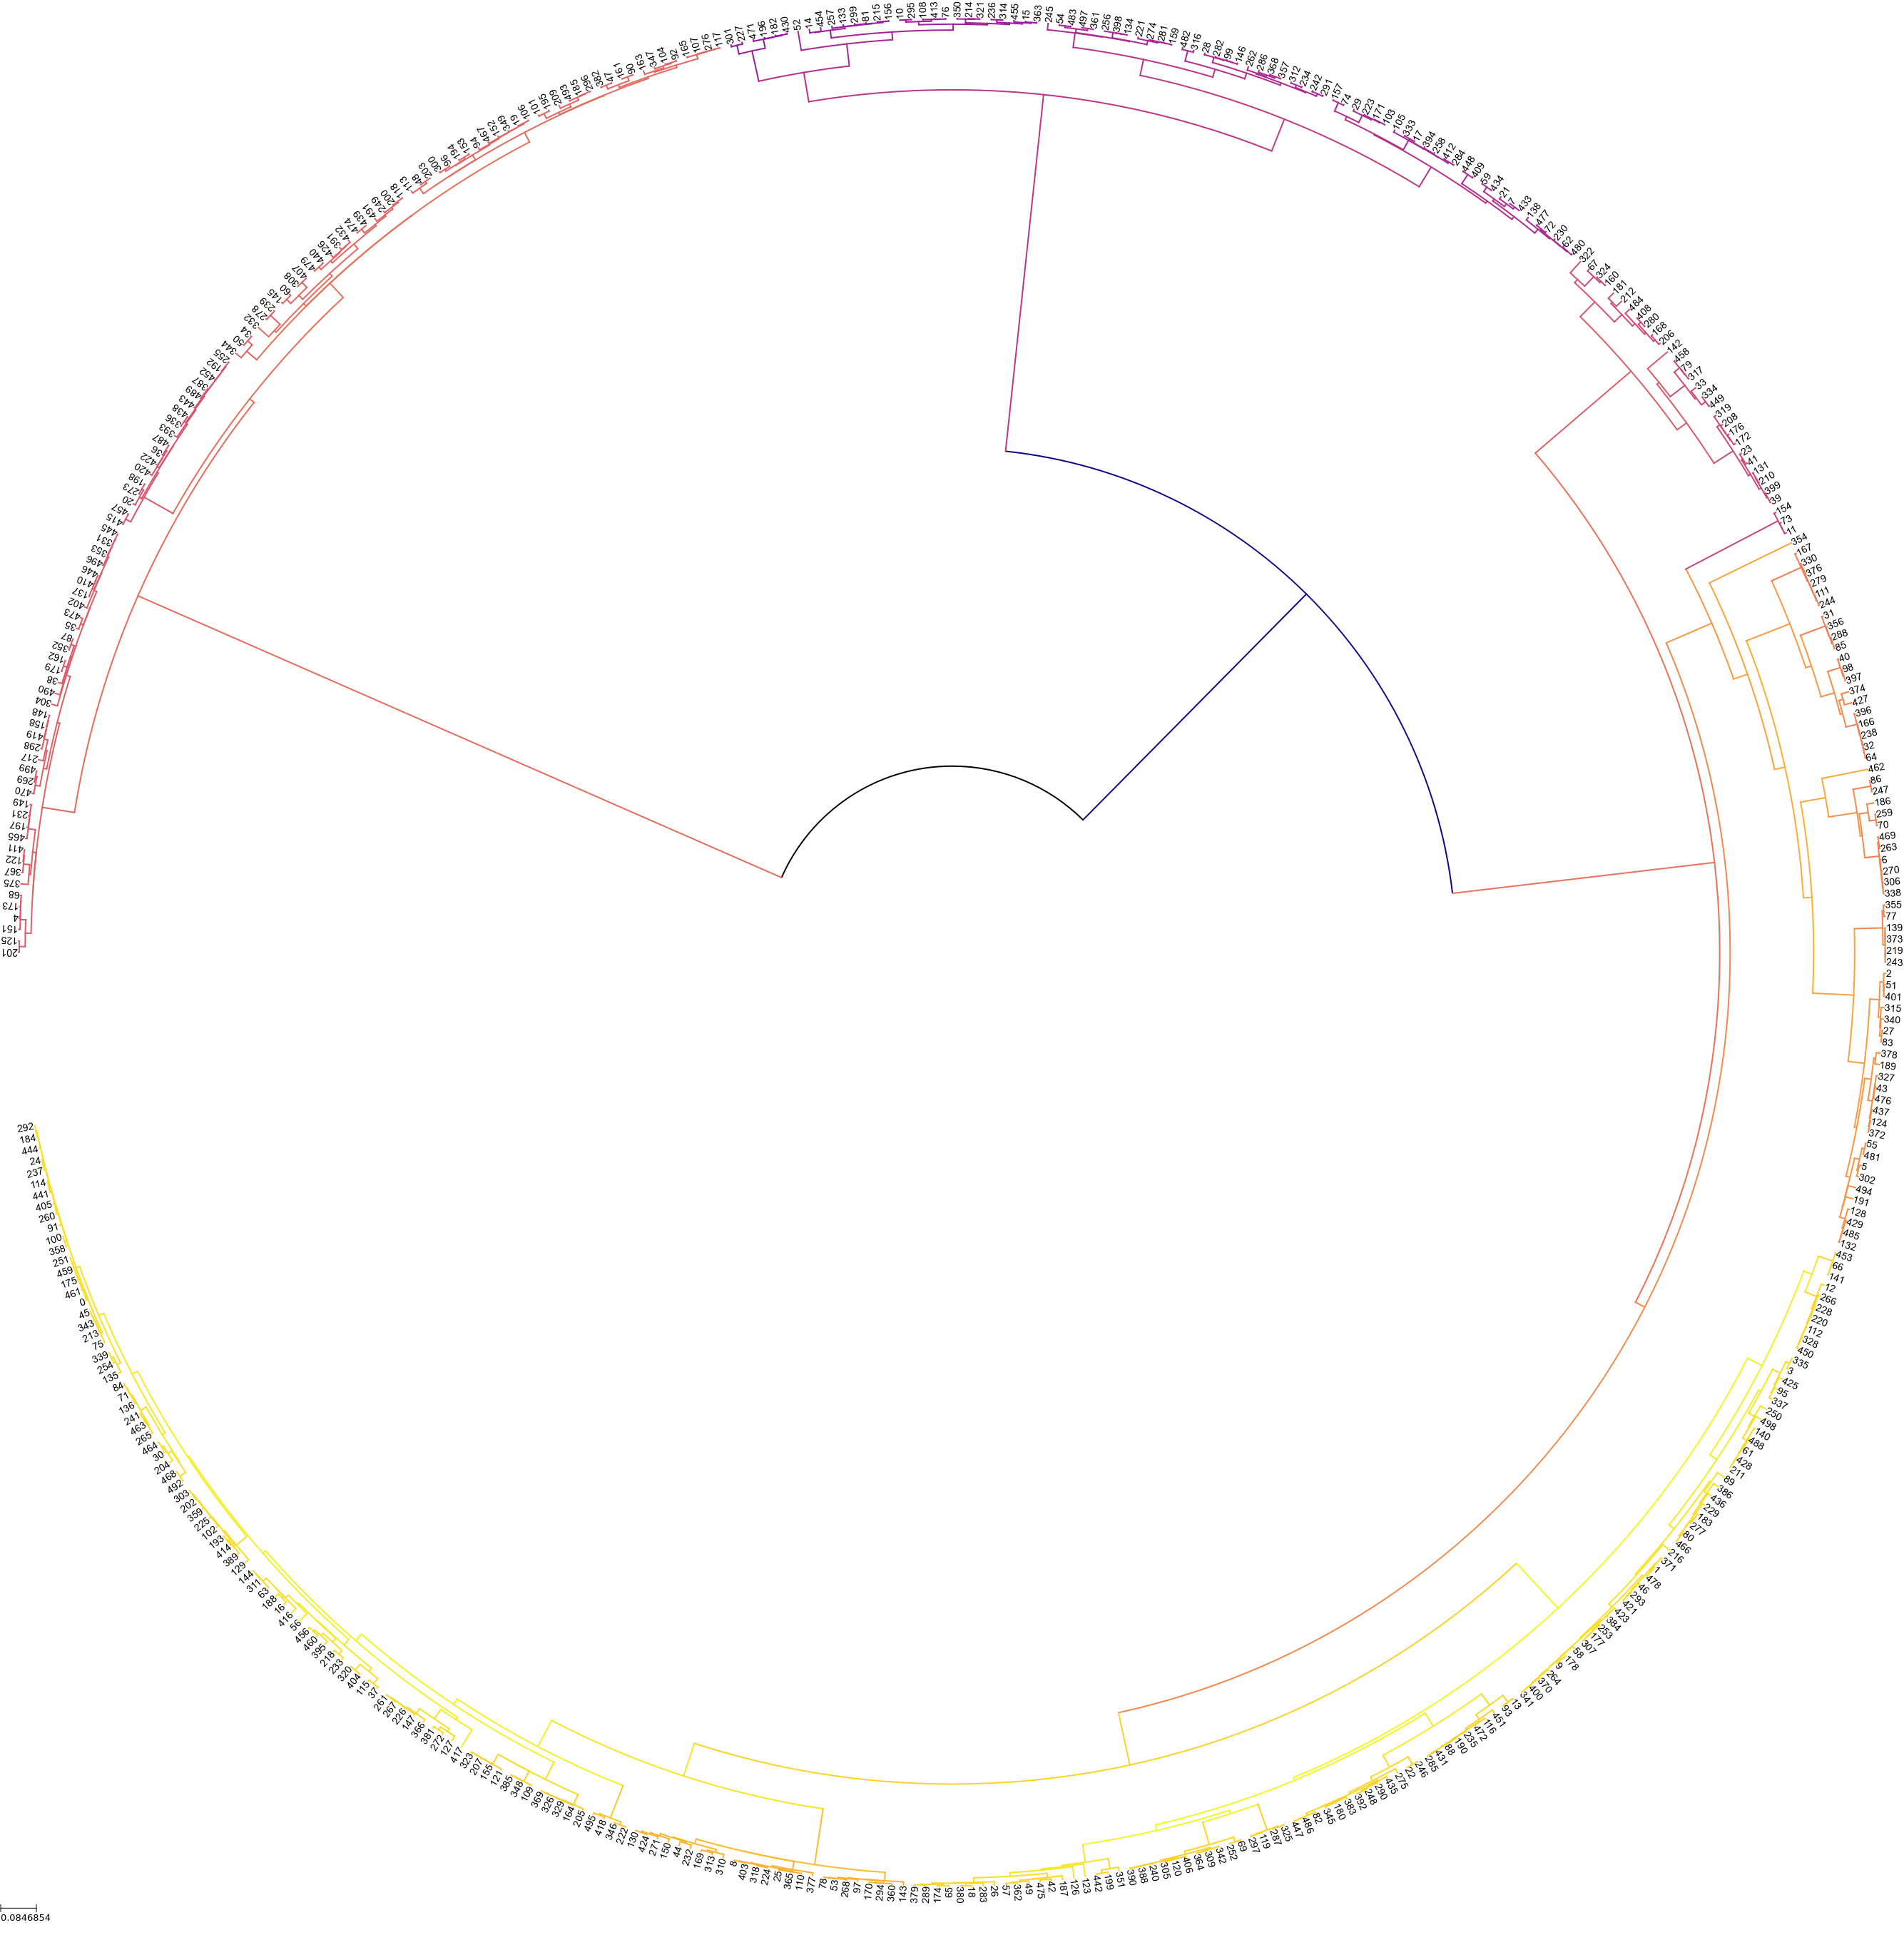

In [13]:
# To visualize inline, uncomment this
# This can be a large output

F_empirical.trees[0].render("%%inline", tree_style=ts)

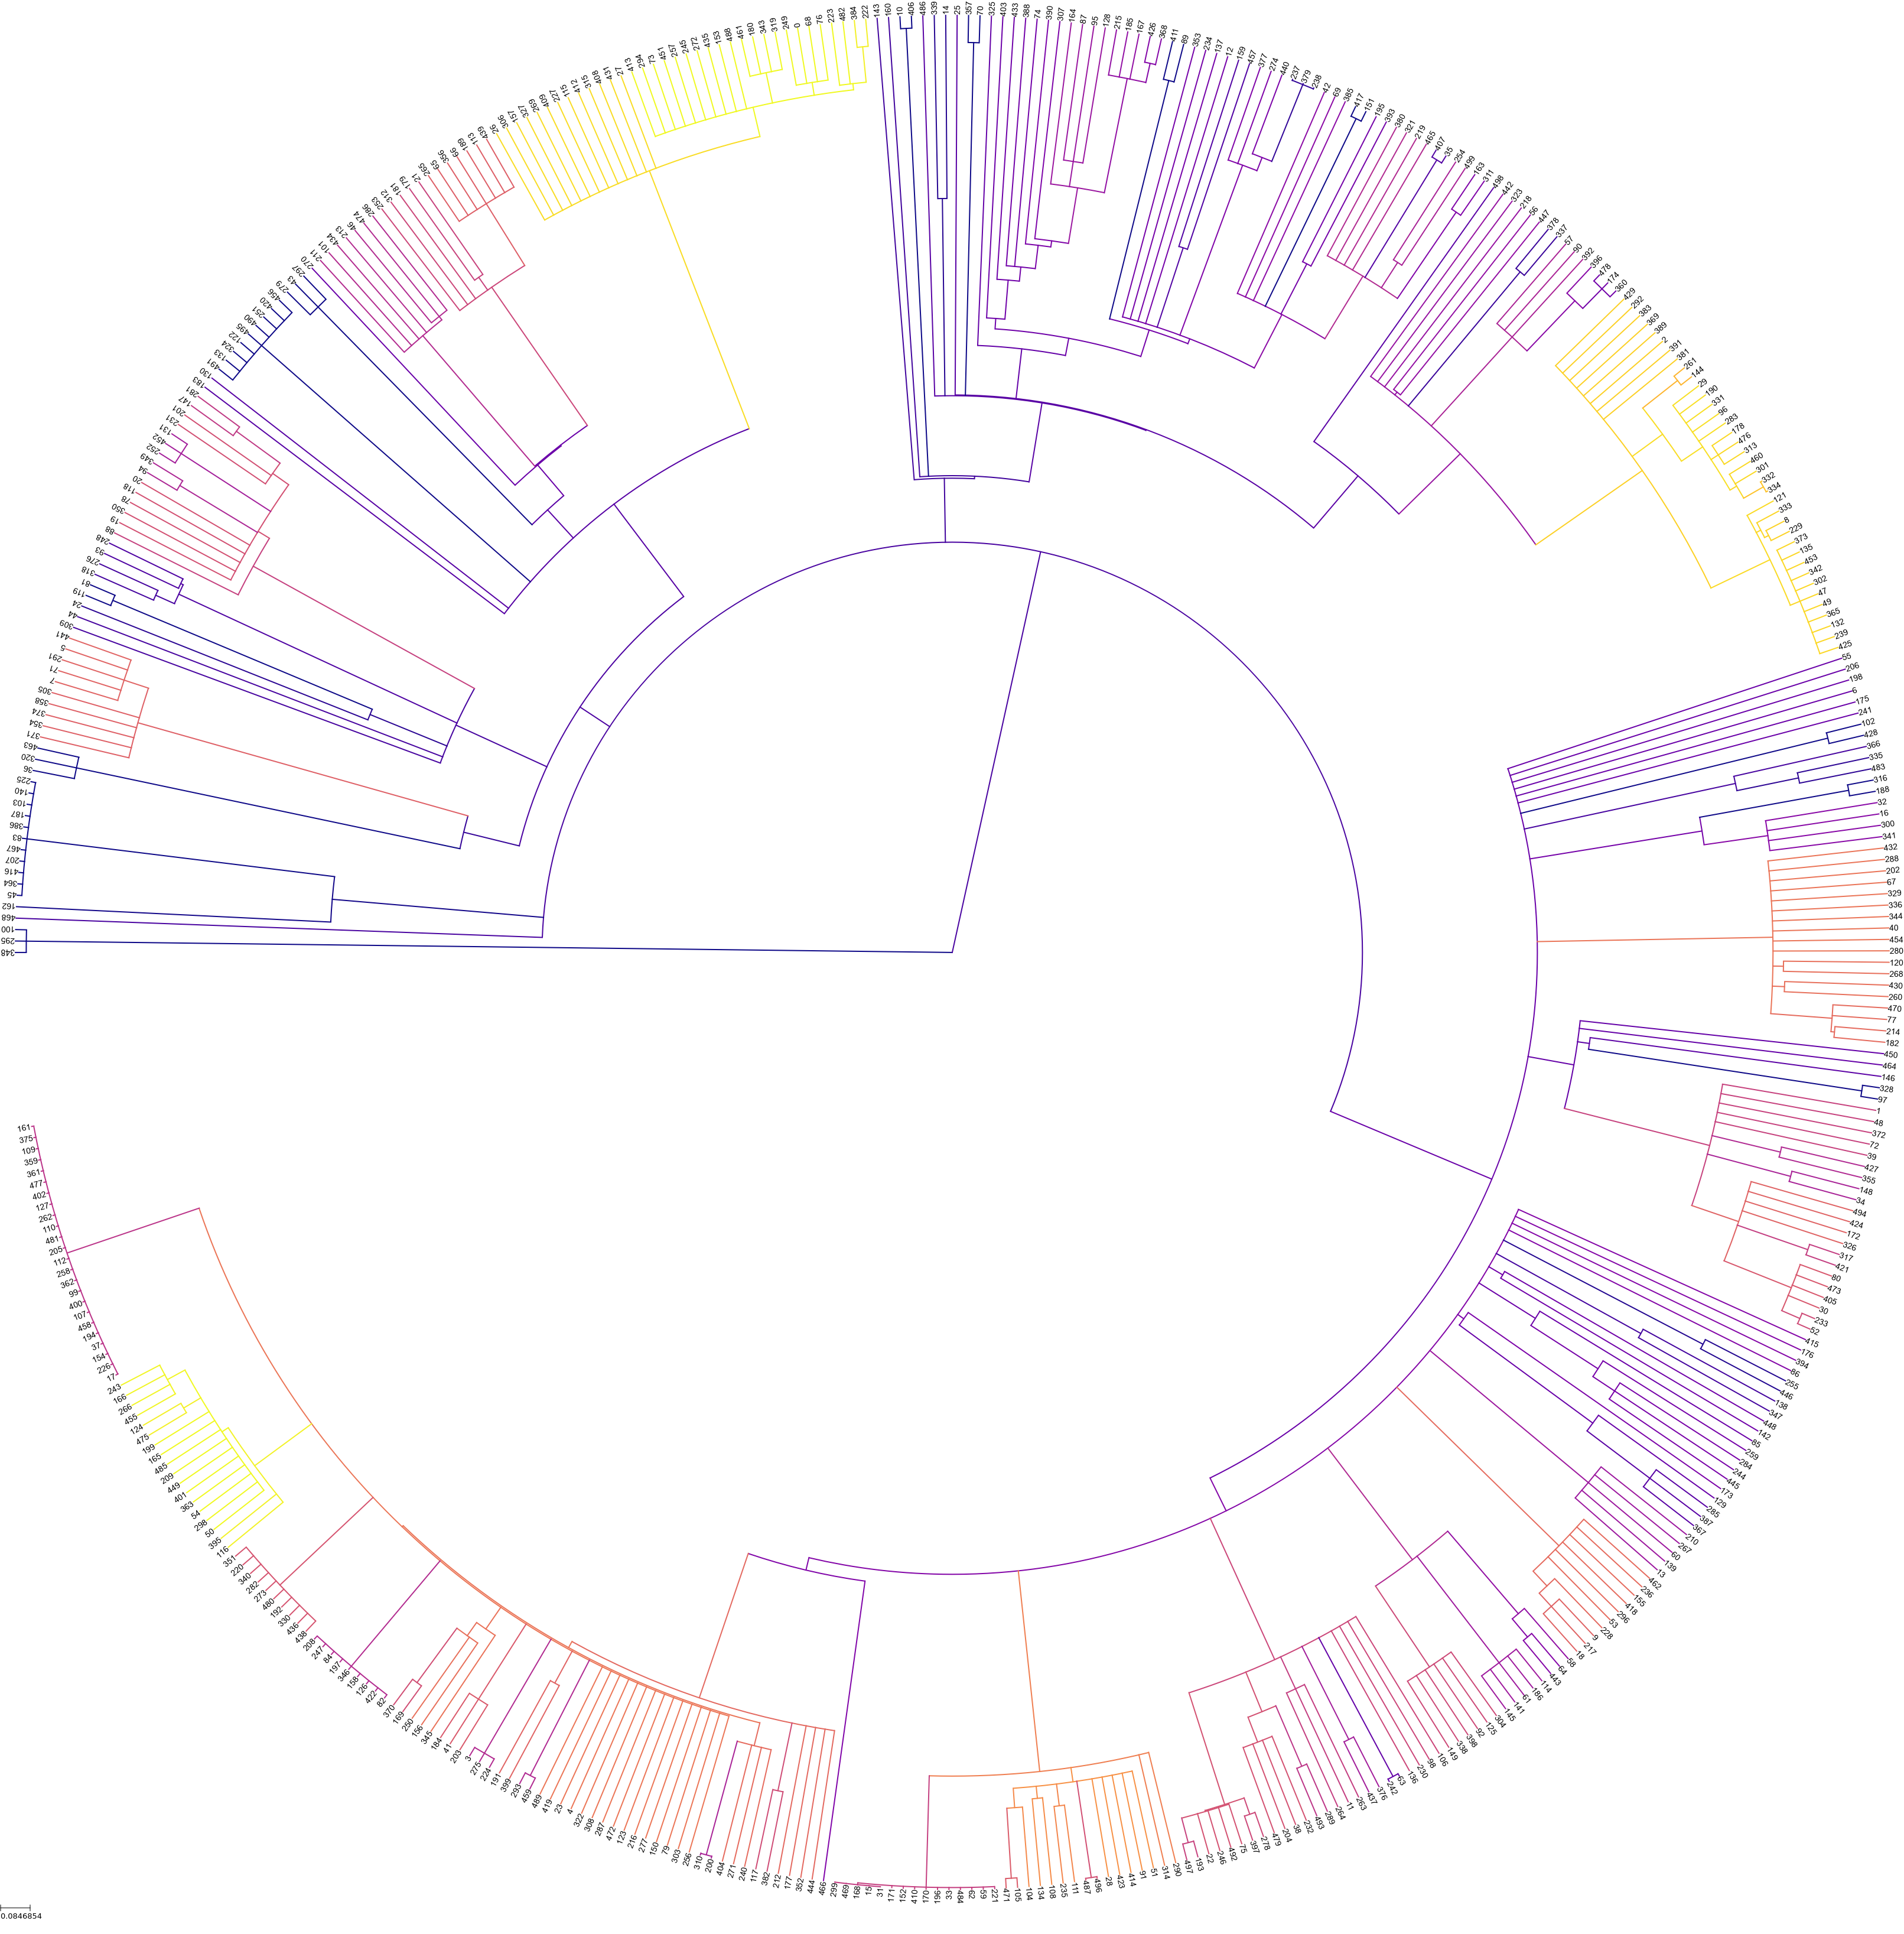

In [14]:
# To visualize inline, uncomment this
# This can be a large output

F_empirical.trees[1].render("%%inline", tree_style=ts)

In [15]:
# Show internal node names

# Set tree style
# Trees are ETE3 objects, so you can use all ETE3 options to change how they are displayed
import ete3
ts_internal_names = ete3.TreeStyle()
ts_internal_names.mode = "c"  # circular trees
ts_internal_names.arc_start = -180
ts_internal_names.arc_span = 350

def layout_internal_names(node):
    F = ete3.TextFace(node.name, tight_text=True)
    ete3.add_face_to_node(F, node, column=0, position="branch-right")

ts_internal_names.layout_fn = layout_internal_names

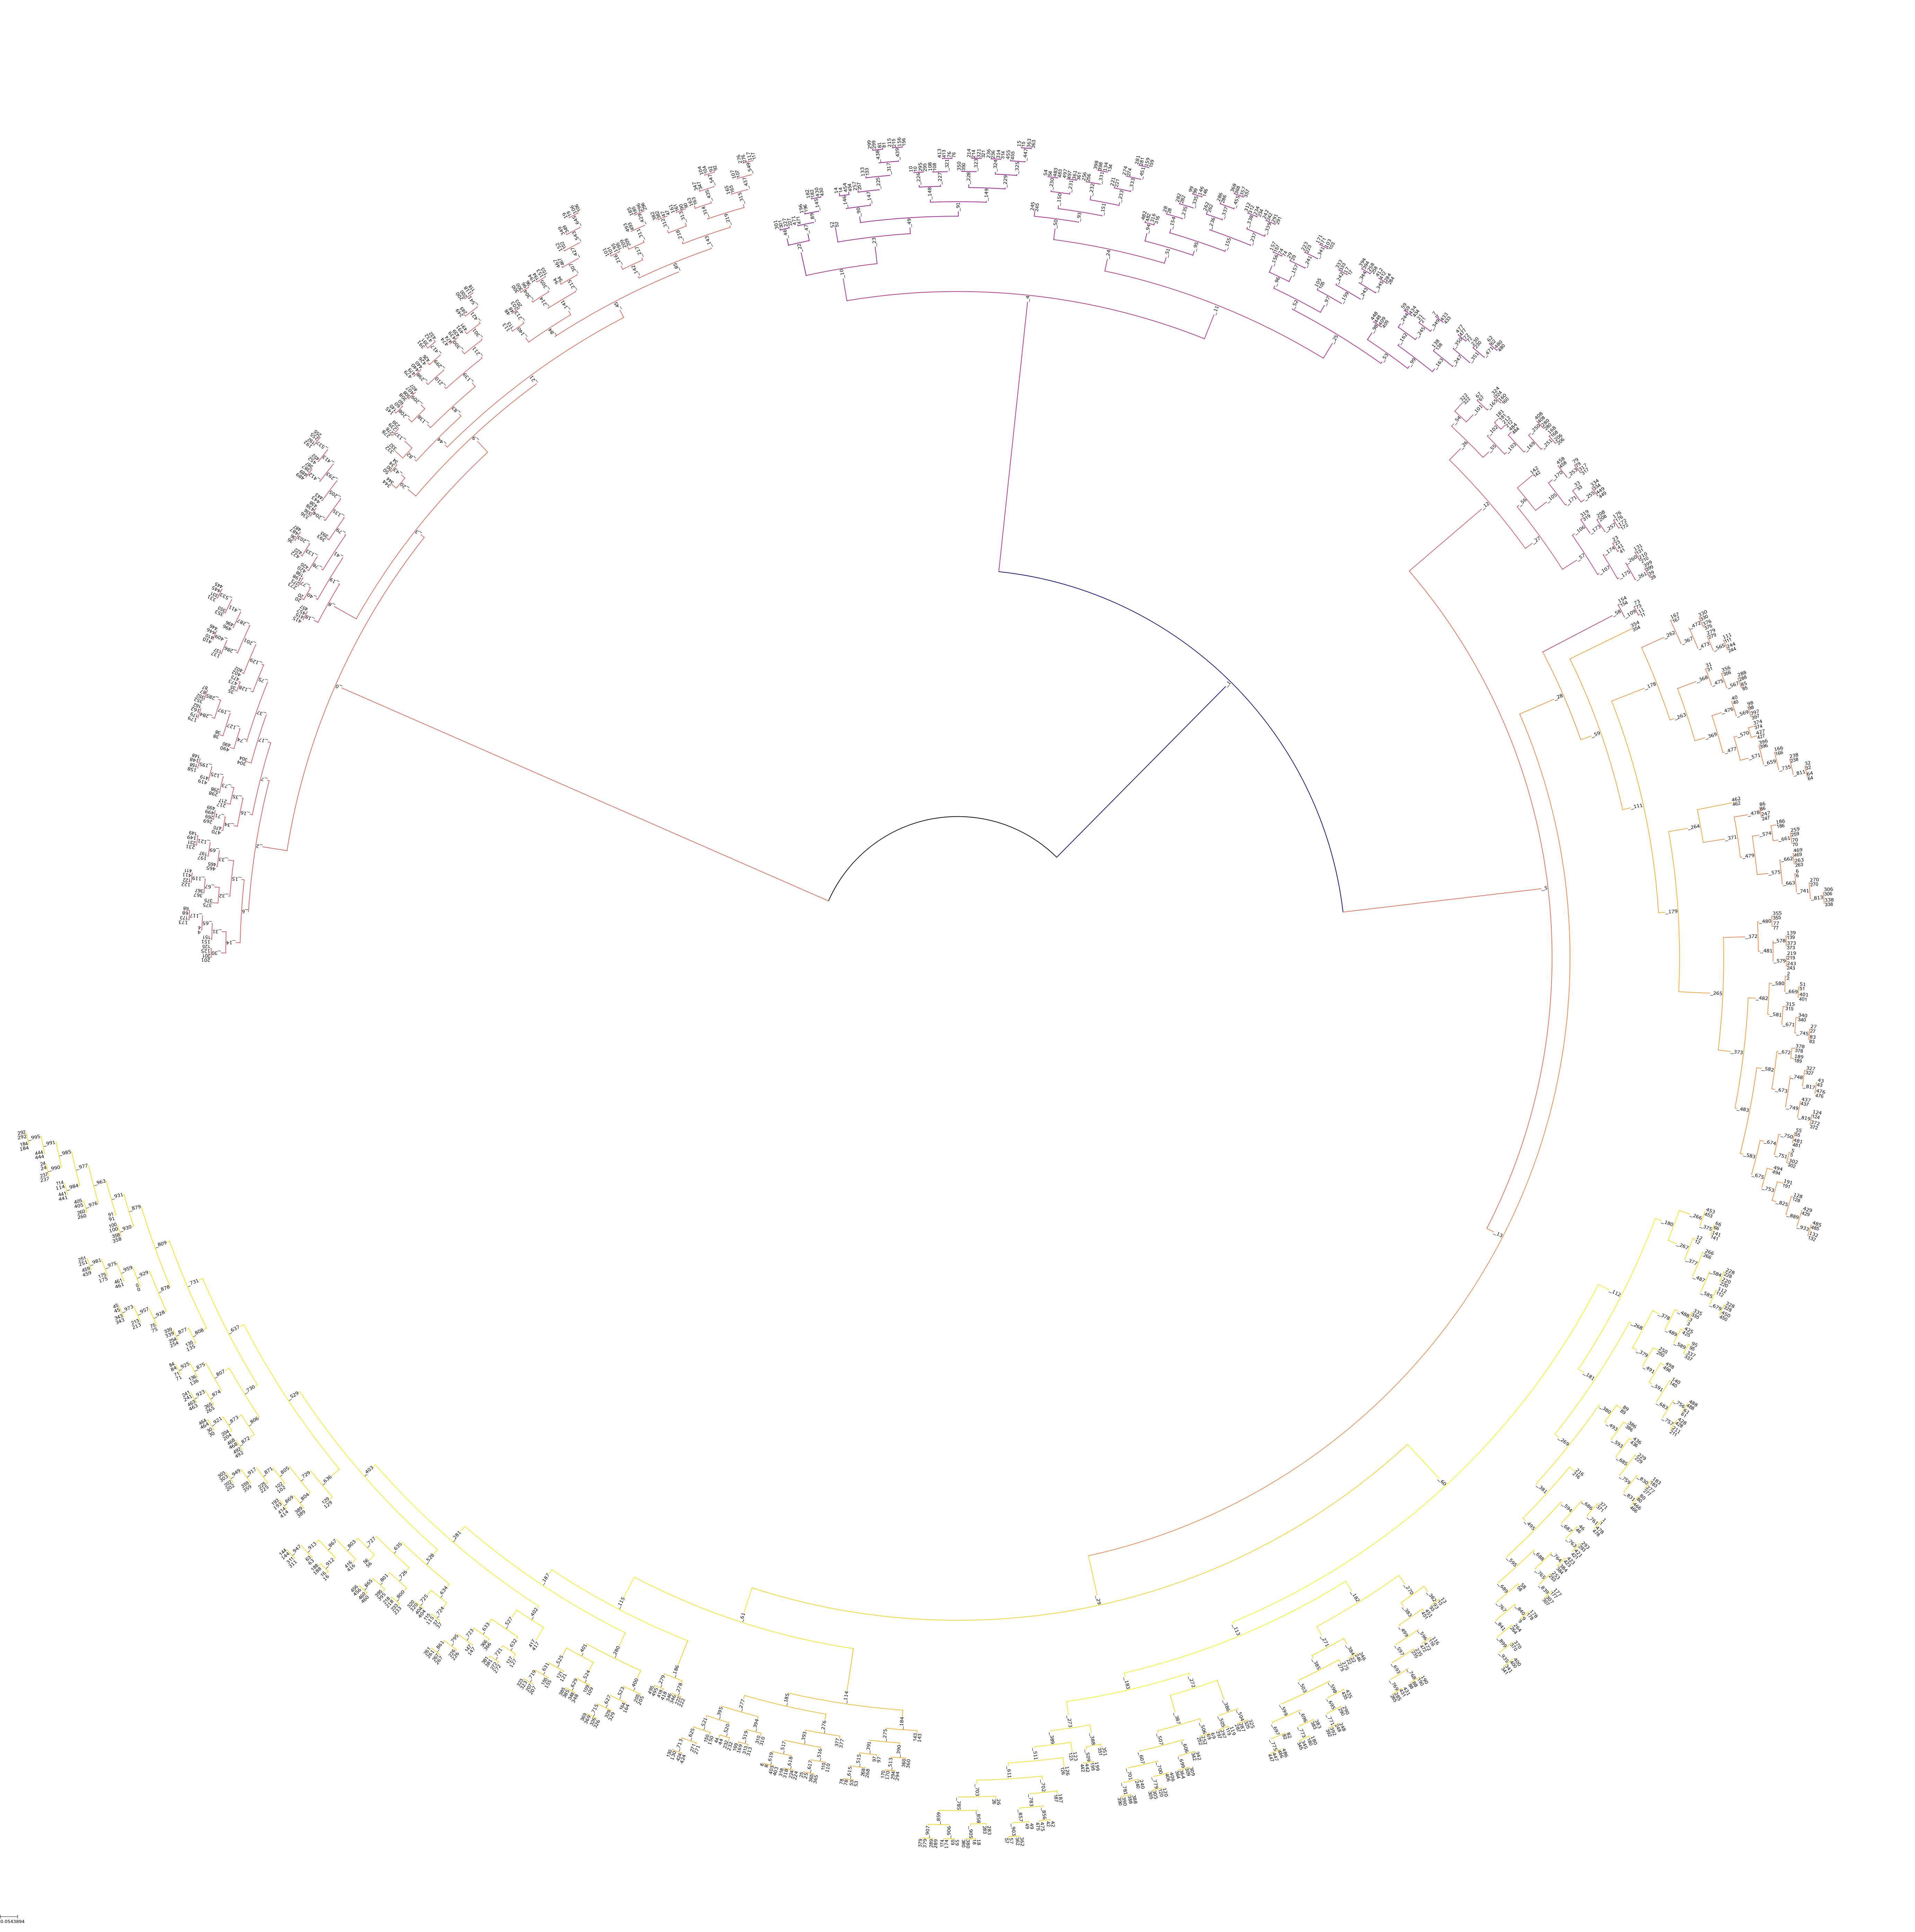

In [16]:
F_empirical.trees[0].render("%%inline", tree_style=ts_internal_names)

# Export trees as Newick

In [17]:
# Save tree as Newick
# Note that this omits any attributes, such as fitness score (this will be added in a future release)
F_empirical.trees[0].to_newick("output.nwk")

In [18]:
# Save tree as Newick with attributes (extended Newick format) (mean fitness in this example)
F_empirical.trees[0].to_newick("output_mean_fitness.nwk", features=["mean_fitness"])

In [19]:
# Save forest as Newick with attributes (compressed in a gzipped tar)
F_empirical.to_newick("output_forest_mean_fitness.nwk.tar.gz", features=["mean_fitness"])

# Examine simple features of nodes

In [20]:
# Get features as a DataFrame
node_features = F_empirical.node_features()
print node_features.shape
node_features.head()

(1670, 15)


rad     dist   rank  num_descendants  \
name_tree id_node                                                 
0         0         407.831403  0.00000    NaN              998   
          1        1960.934369  1.66768  286.0              216   
          2        1121.126354  0.75414  499.0              780   
          3        2052.253034  0.07757  318.0               76   
          4        1993.041353  0.01316  284.0              138   

                   expansion_score  var_fitness name  mean_fitness  support  \
name_tree id_node                                                             
0         0                    NaN          NaN                NaN      1.0   
          1              -0.021761     0.583077   _0      4.840473      1.0   
          2              -0.003331     0.106822   _1      2.184208      1.0   
          3              -0.034720     0.716852   _2      4.709948      1.0   
          4              -0.028087     0.603630   _3      4.872570      1.0   

                   num_children  _nid  depth_normalized    depth  \
name_tree id_node                                                  
0         0                   2     0          0.000000  0.00000   
          1                   2     1          0.939787  1.66768   
          2                   2   218          0.424980  0.75414   
          3                   2     2          0.983500  1.74525   
          4                   2    79          0.947203  1.68084   

                   num_leaf_descendants  is_leaf  
name_tree id_node                                 
0         0                         500    False  
          1                         109    False  
          2                         391    False  
          3                          39    False  
          4                          70    False

/scratch/resources/anaconda3/envs/jungle/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


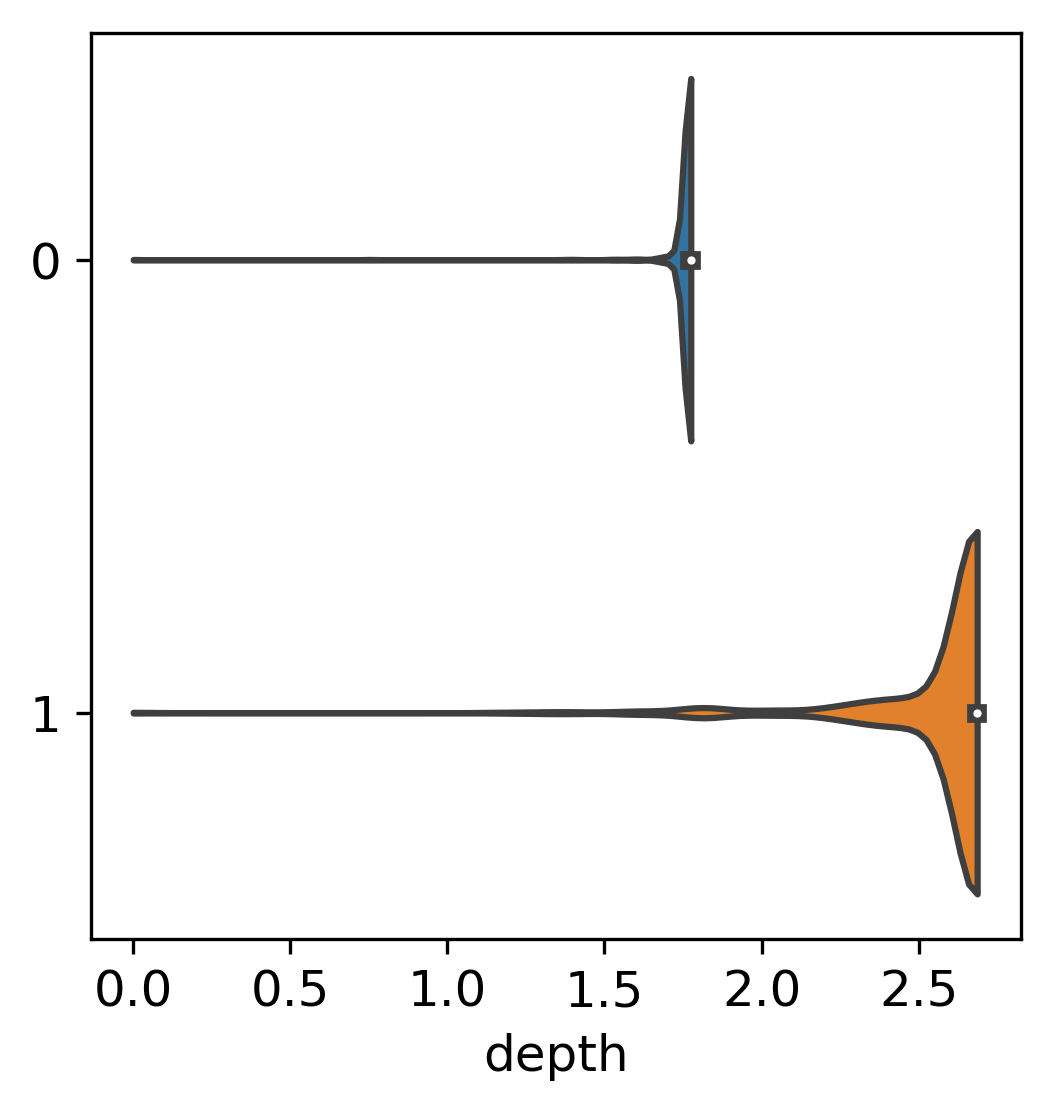

In [21]:
# Distribution of depth
data = node_features.reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.violinplot(x=data["depth"], y=data["name_tree"].astype('category'), ax=ax, cut=0, scale="width")
ax.set_ylabel("")

# Example of saving plot to file
fig.savefig("violin_depth.png")

Text(0.5,0,'log10(descendants + 1)')

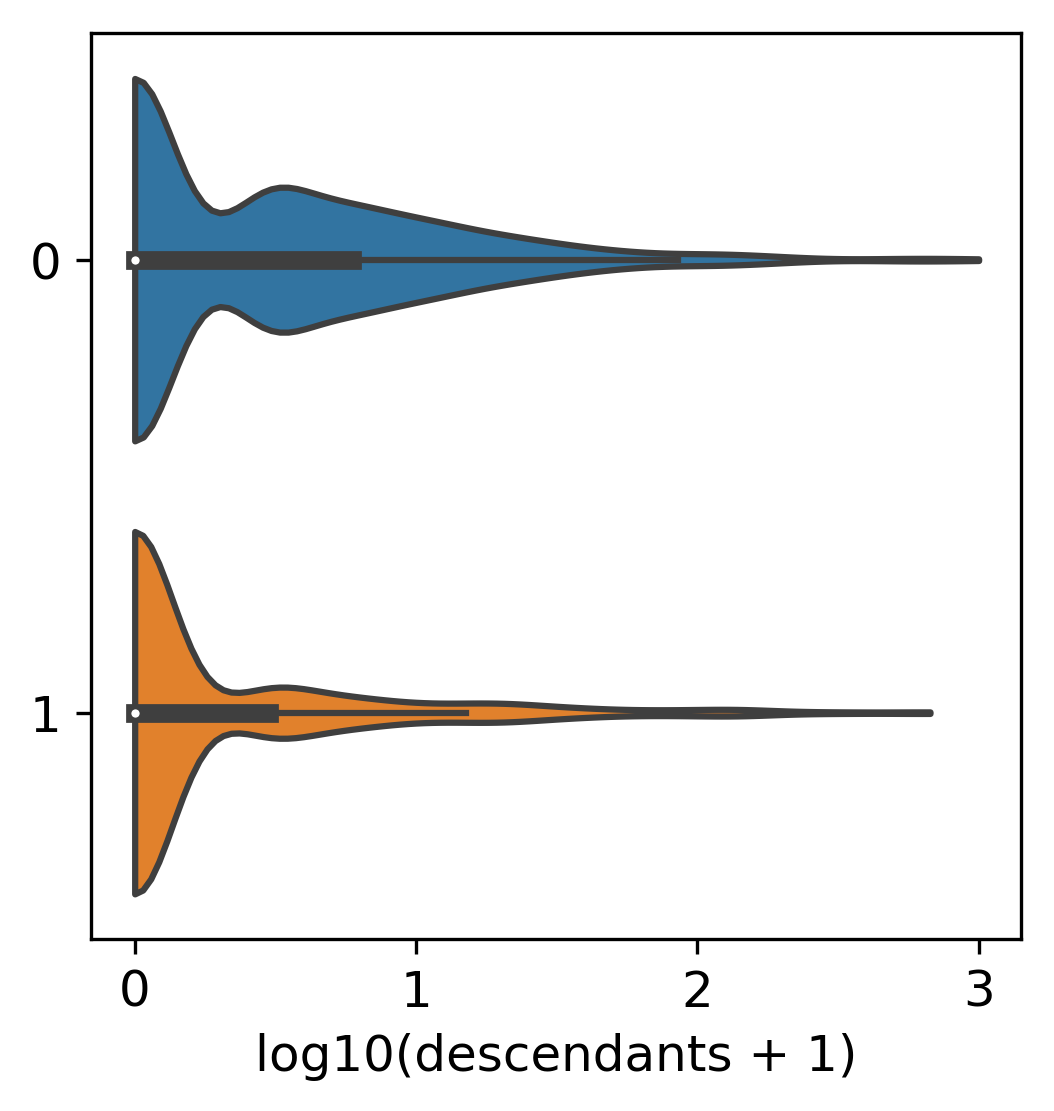

In [22]:
# Distribution of num descendants
data = node_features.reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.violinplot(x=np.log10(data["num_descendants"] + 1), y=data["name_tree"].astype('category'), ax=ax, cut=0, scale="width")
ax.set_ylabel("")
ax.set_xlabel("log10(descendants + 1)")

Text(0,0.5,'')

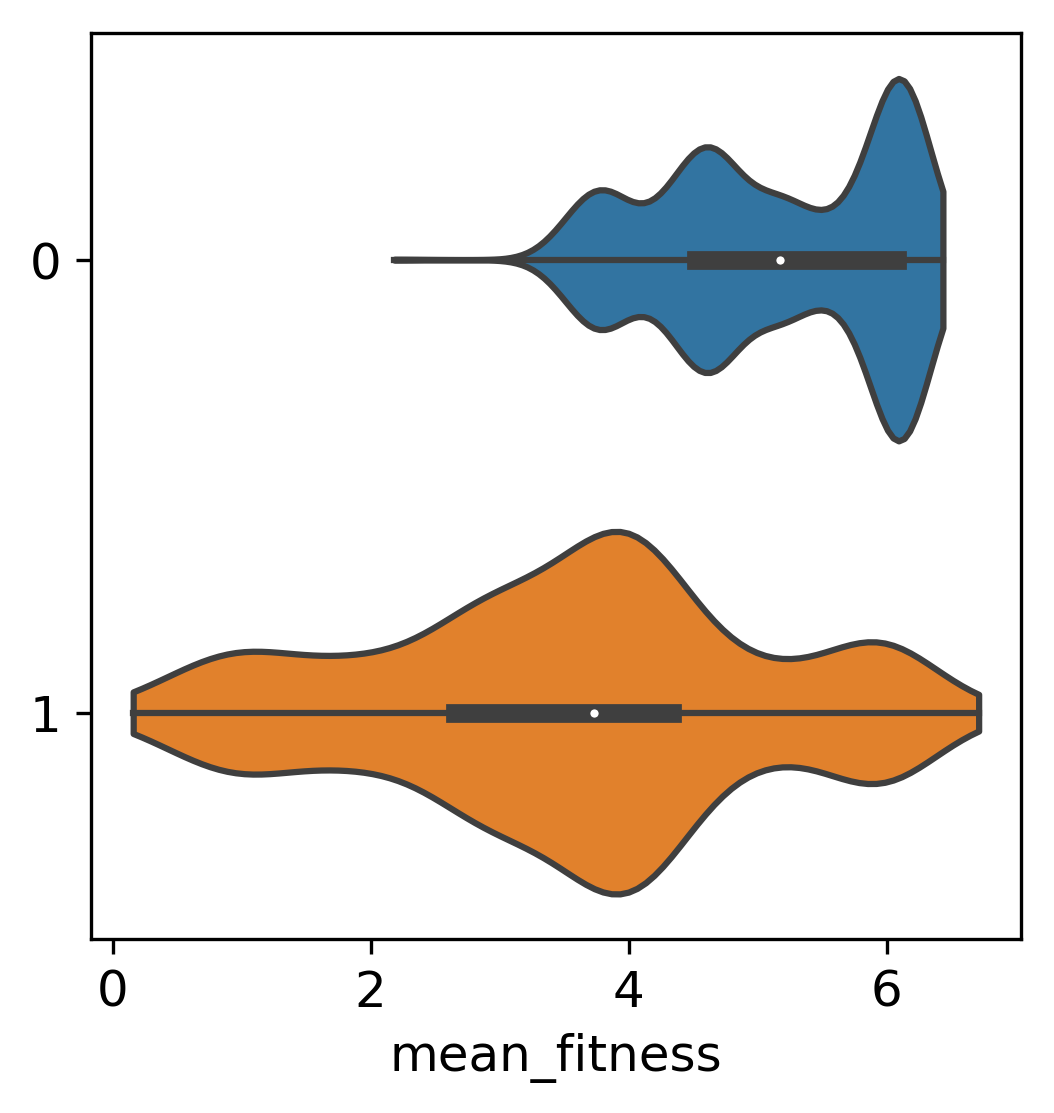

In [23]:
# Distribution of mean fitness
data = node_features.reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.violinplot(x=data["mean_fitness"], y=data["name_tree"].astype('category'), ax=ax, cut=0, scale="width")
ax.set_ylabel("")

Text(0,0.5,'')

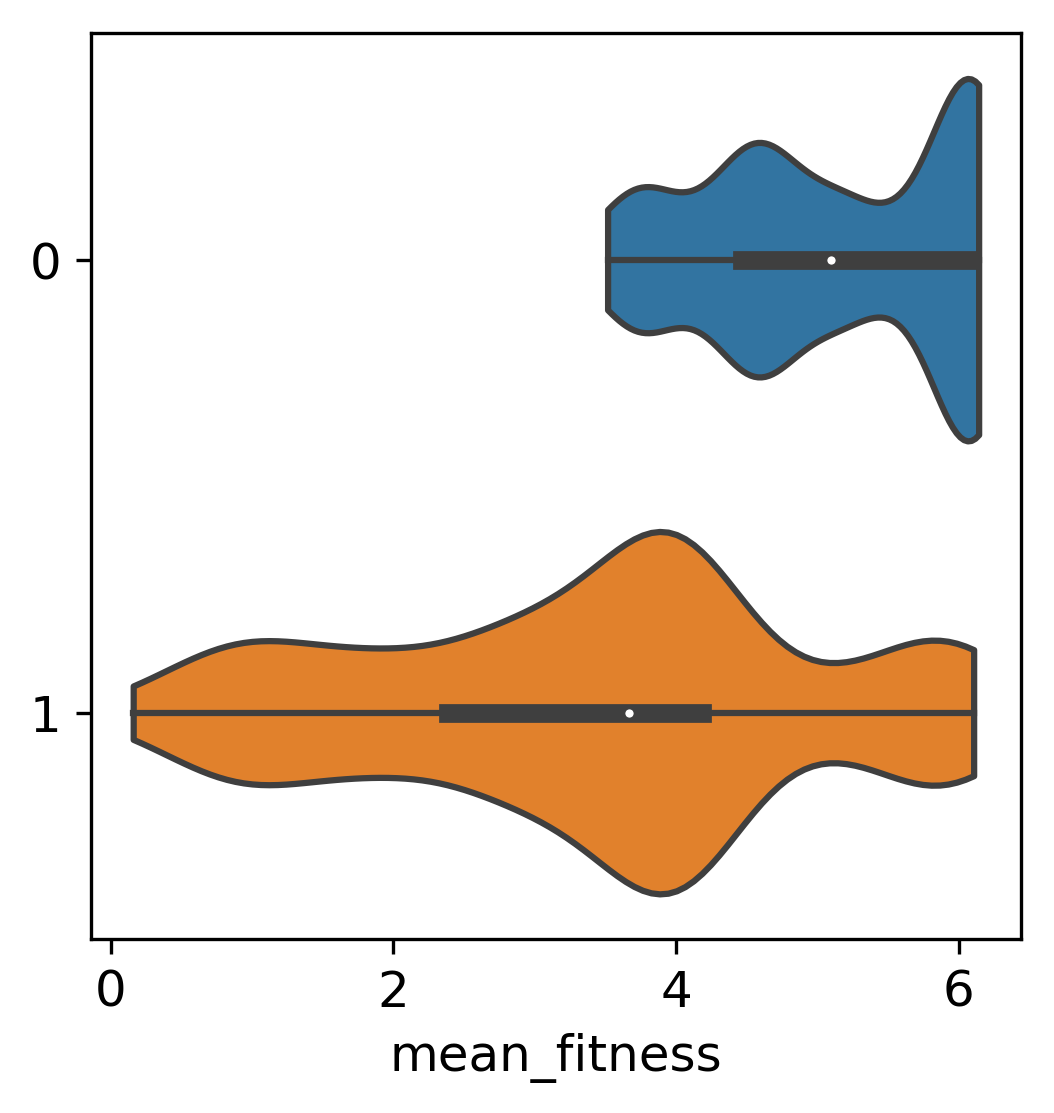

In [24]:
# Distribution of mean fitness among leaves
data = node_features.loc[node_features["is_leaf"] == True].reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.violinplot(x=data["mean_fitness"], y=data["name_tree"].astype('category'), ax=ax, cut=0, scale="width")
ax.set_ylabel("")

Text(0,0.5,'')

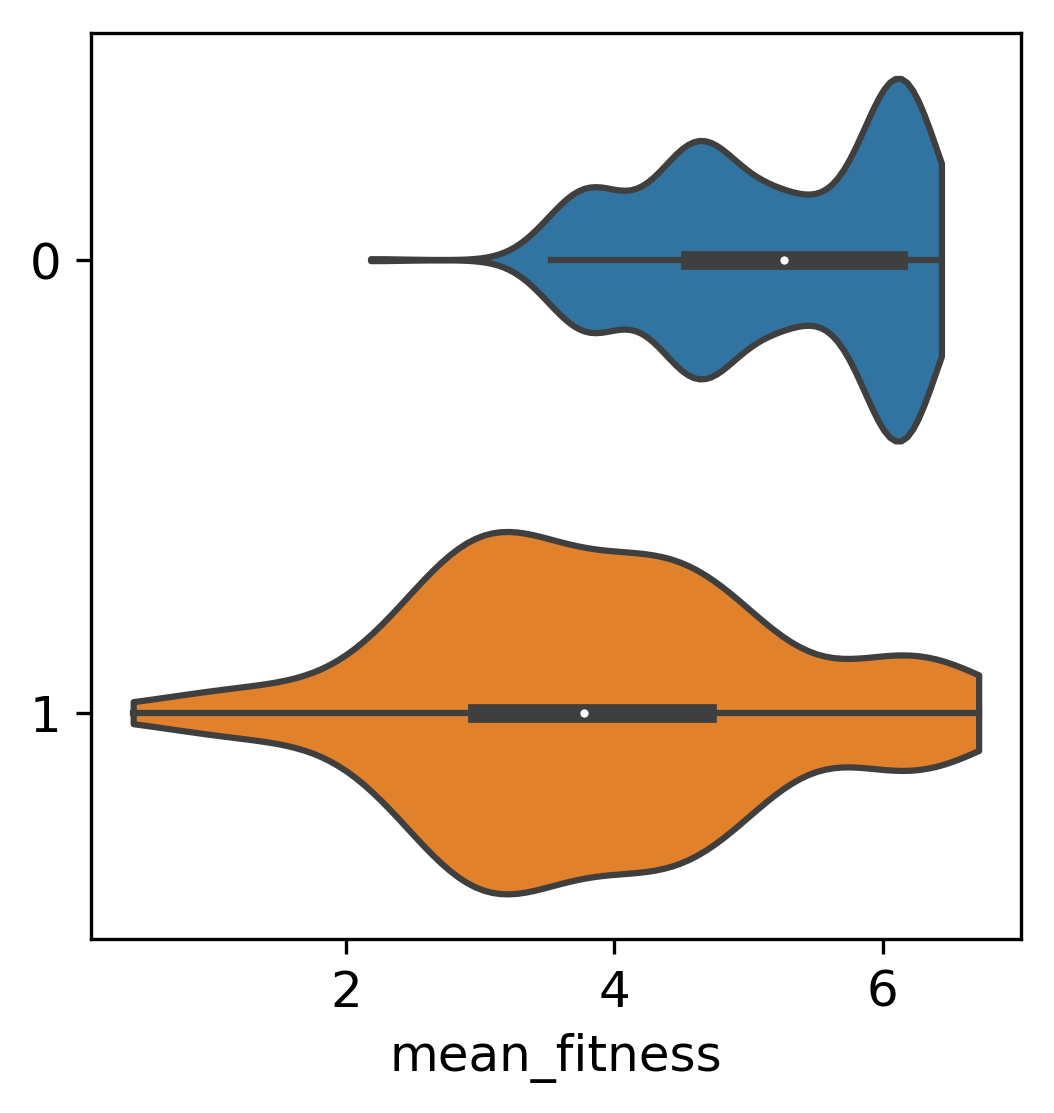

In [25]:
# Distribution of mean fitness among internal nodes
data = node_features.loc[node_features["is_leaf"] == False].reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.violinplot(x=data["mean_fitness"], y=data["name_tree"].astype('category'), ax=ax, cut=0, scale="width")
ax.set_ylabel("")

Text(0,0.5,'')

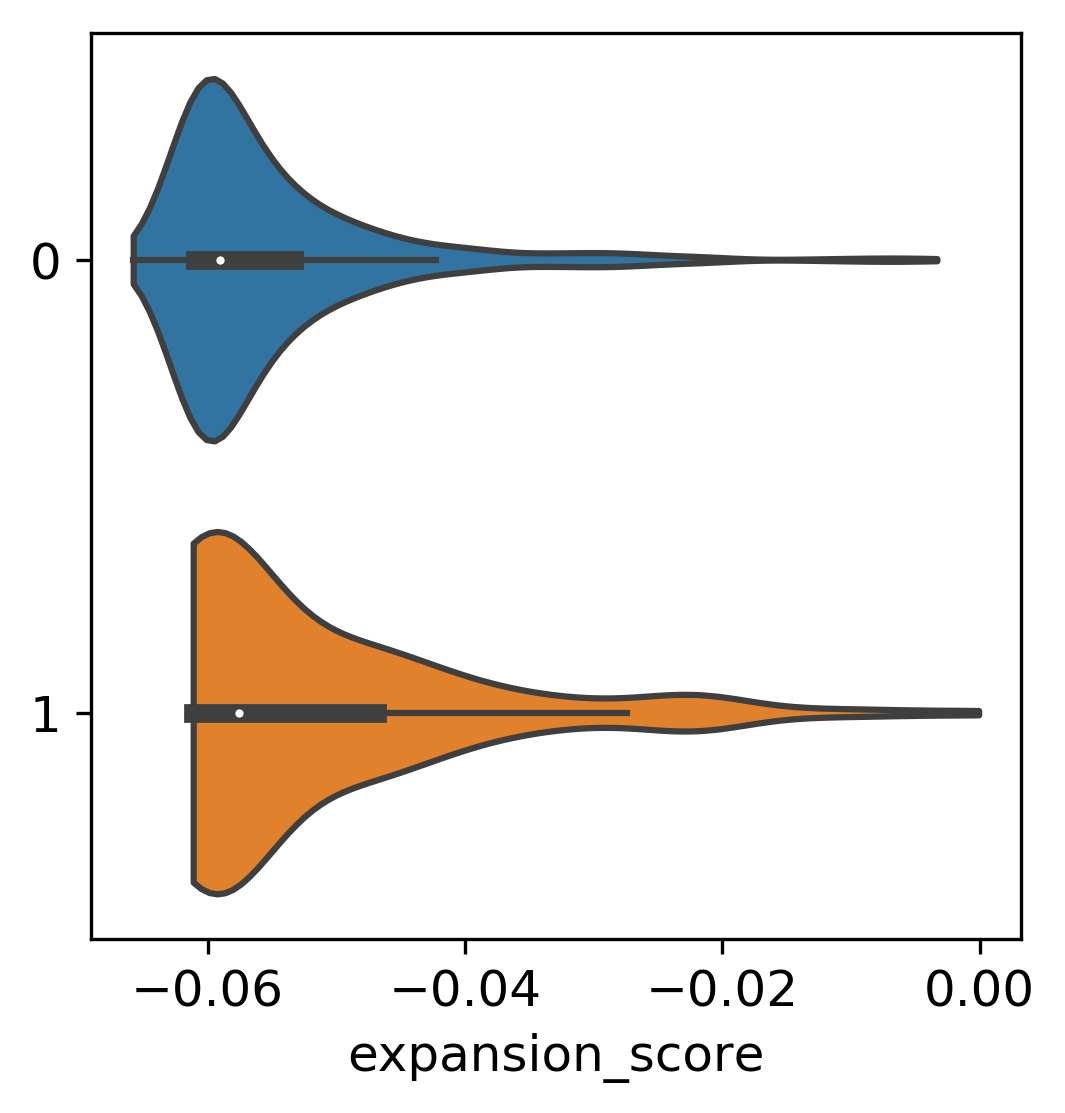

In [26]:
# Distribution of expansion score
data = node_features.reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.violinplot(x=data["expansion_score"], y=data["name_tree"].astype('category'), ax=ax, cut=0, scale="width")
ax.set_ylabel("")

# Examine how fitness score relates to other features of nodes

SpearmanrResult(correlation=0.12493310679307267, pvalue=7.578684961161053e-05)
SpearmanrResult(correlation=0.10945749113416922, pvalue=0.004561478839339458)


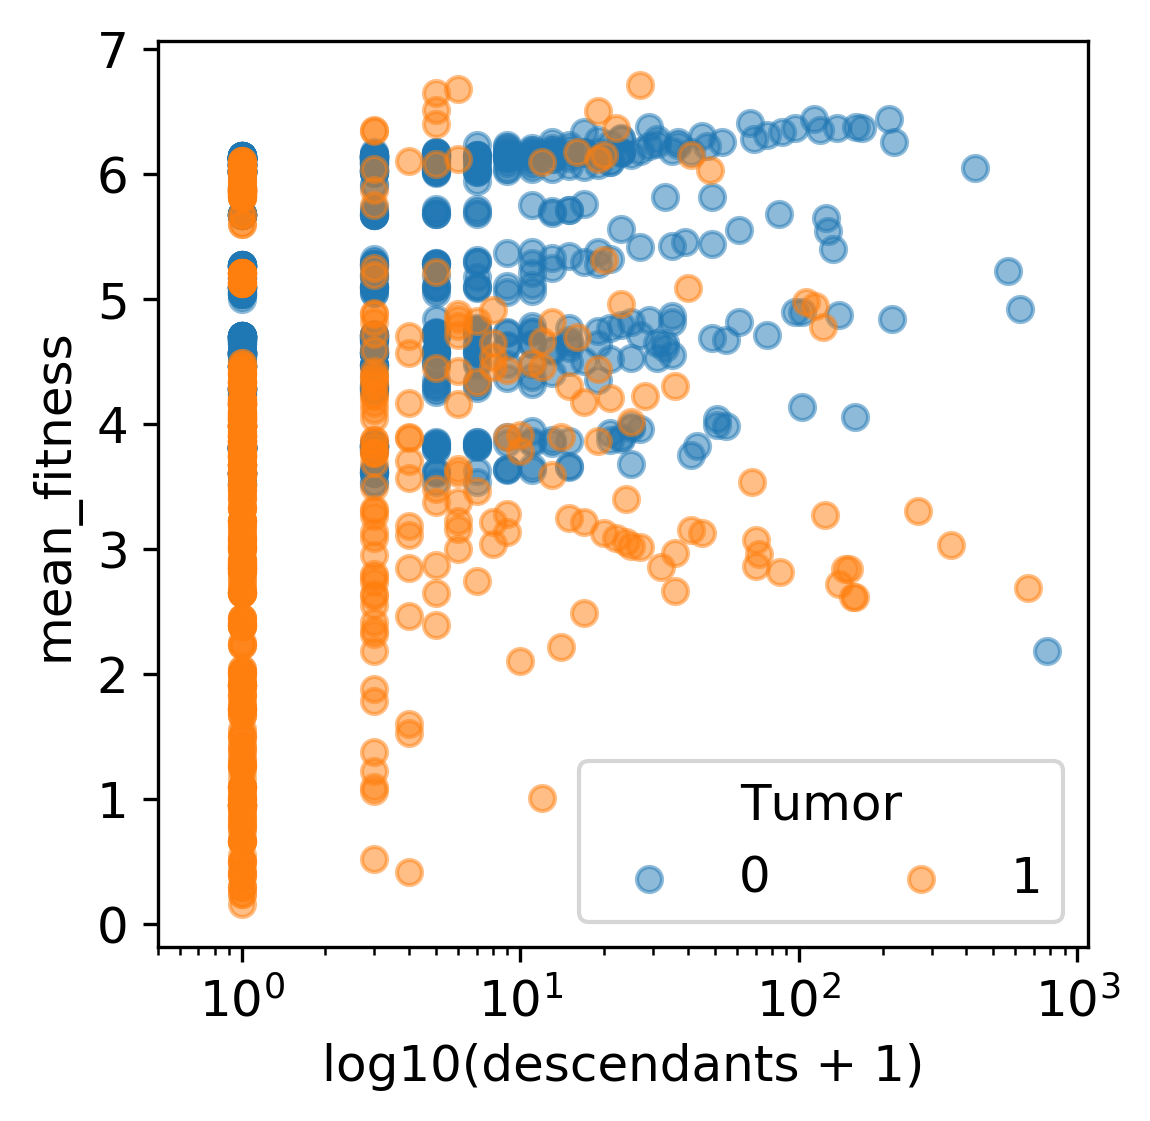

In [27]:
# Correlation of num descendants with fitness

fig, ax = plt.subplots(1, 1, figsize=(4,4))

for name_tree, group in data.groupby("name_tree"):
    
    x = group["num_descendants"] + 1
    y = group["mean_fitness"]
    ax.scatter(x, y, label=name_tree, alpha=0.5)
    
    print scipy.stats.spearmanr(x, y, nan_policy="omit")

ax.set_xscale("log")
ax.set_xlim(left=0.5)
ax.set_xlabel("log10(descendants + 1)")
ax.set_ylabel("mean_fitness")
ax.legend(loc = "lower right", ncol=2, title="Tumor")

SpearmanrResult(correlation=0.9911269122850433, pvalue=0.0)
SpearmanrResult(correlation=0.9967917161584128, pvalue=3.506585937615763e-186)


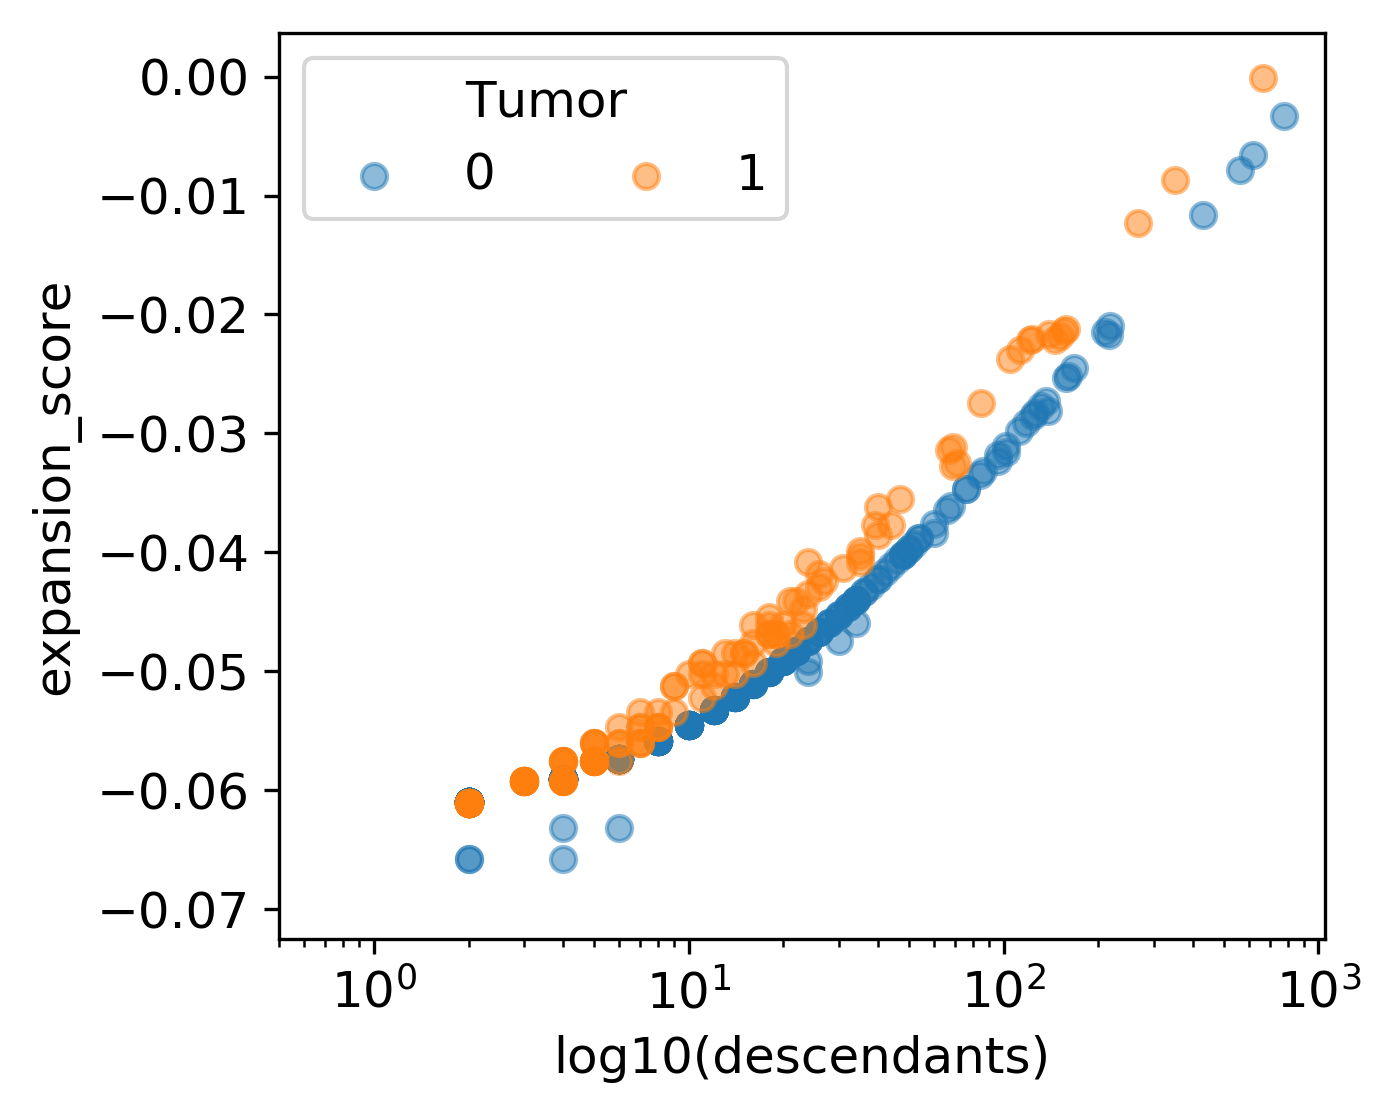

In [28]:
# Correlation of num descendants with expansion score


fig, ax = plt.subplots(1, 1, figsize=(4.5,4))

for name_tree, group in data.groupby("name_tree"):
    
    x = group["num_descendants"]
    y = group["expansion_score"]
    ax.scatter(x, y, label=name_tree, alpha=0.5)
    
    print scipy.stats.spearmanr(x, y, nan_policy="omit")

ax.set_xscale("log")
ax.set_xlim(left=0.5)
ax.set_xlabel("log10(descendants)")
ax.set_ylabel("expansion_score")
ax.legend(loc = "upper left", ncol=2, title="Tumor")

# Save nodes with annotations to file

In [29]:
# Replace names with names given by original Newick files
name_tree_to_original = dict(zip(range(len(names_trees)), names_trees))
name_tree_original = [name_tree_to_original[x] for x in node_features.index.get_level_values("name_tree")]
node_features["name_tree_original"] = name_tree_original # add column specifying original tree name

In [30]:
# Save to TSV file
node_features.to_csv("node_features.tsv", sep="\t")

In [31]:
# Filter nodes for leaves
node_features_leaves = node_features.loc[node_features["is_leaf"] == True]

# Save to TSV file
node_features_leaves.to_csv("node_features_leaves.tsv", sep="\t")